In [ ]:
# source activate python_311
# pip install https://github.com/pmosconi/scallop/raw/master/target/wheels/scallopy-0.2.5-cp311-cp311-manylinux_2_34_x86_64.whl
# pip install torchvision 
# pip install scikit-learn seaborn

In [5]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# import google.colab
import os
import random
import scallopy
from tqdm import tqdm

In [18]:
def set_seed(seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [8]:
# google.colab.drive.mount('/content/drive')

In [32]:
PROJECT_DIR = "./"
dataset_path = "sudoku_grids_dataset"

20250319_161440_detection.jpg
(400, 400) uint8


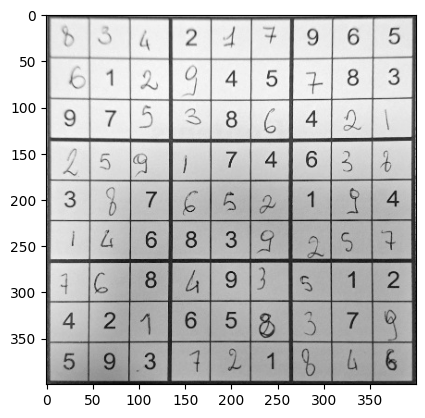

IMG_3230_detection.jpg
(400, 400) uint8


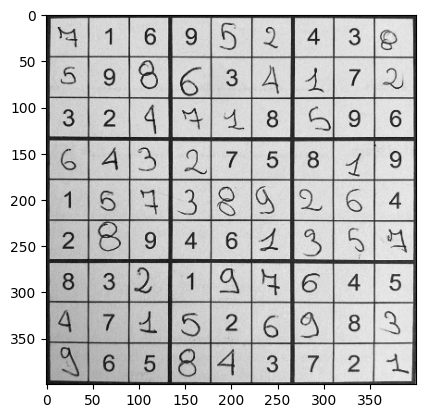

In [20]:
for folder in os.listdir(dataset_path):
  folder_list = [filename for filename in os.listdir(os.path.join(dataset_path, folder))]
  print(folder_list[0])
  image = plt.imread(os.path.join(dataset_path, f"{folder}/{folder_list[0]}"))
  plt.imshow(image, cmap="gray")
  print(image.shape, image.dtype)
  plt.show()

In [21]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [22]:
print(f"Dataset size: {len(dataset)} images")
print(f"Class mapping: {dataset.class_to_idx}")

Dataset size: 780 images
Class mapping: {'invalid': 0, 'valid': 1}


In [23]:
sample_img, _ = dataset[0]
print(f"Sample image shape: {sample_img.shape}")

Sample image shape: torch.Size([1, 400, 400])


In [24]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [25]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = 8,
                                           shuffle=True,
                                           num_workers=2
                                           )

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size = 8,
                                           shuffle=False,
                                           num_workers=2
                                           )

(tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]]), 1)
torch.Size([1, 400, 400]) torch.float32
tensor([[[-0.0510, -0.0588, -0.0745,  ..., -0.3412, -0.3098, -0.2471],
         [-0.1686, -0.2078, -0.2471,  ..., -0.5608, -0.4824, -0.3882],
         [-0.3098, -0.3882, -0.4745,  ..., -0.6863, -0.6314, -0.5529],
         ...,
         [-0.6941, -0.7569, -0.8118,  ..., -0.8118, -0.7961, -0.7647],
         [-0.6078, -0.7020, -0.7569,  ..., -0.7255, -0.7020, -0.6706],
         [-0.5373, -0.6235, -0.6549,  ..., -0.6627, -0.6471, -0.6157]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([8, 1, 400, 400]) torch.float32
torch.Size([8]) torch.int64


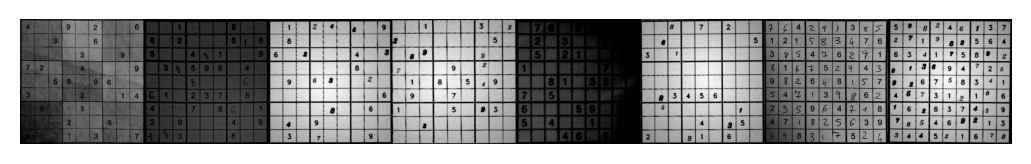

In [26]:
print(train_set[0])
print(train_set[0][0].shape, train_set[0][0].dtype)
print(train_set[0][0])

#function to visualize the images
def show_batch(images):
  g = torchvision.utils.make_grid(images, nrow=8)
  g = g.numpy().transpose((1, 2, 0))
  plt.figure(dpi=200)
  plt.imshow(g)
  plt.axis("off")
  plt.show()

images, labels = next(iter(train_loader))
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)
show_batch(images)

In [27]:
def crop_cell_image_torch(image, grid_dim, cell_pixel_size, orig_cell_pos):
  cell_pos = (orig_cell_pos[1], orig_cell_pos[0])
  cell_w, cell_h = cell_pixel_size
  agent_offset_x, agent_offset_y = cell_pos[0]*cell_w, cell_pos[1]*cell_h
  agent_end_x, agent_end_y = agent_offset_x + cell_w, agent_offset_y + cell_h
  return image[:, agent_offset_y:agent_end_y, agent_offset_x:agent_end_x]

In [28]:
class CellClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = torch.nn.Sequential(
        self.make_block(1, 16),
        self.make_block(16, 32),
        self.make_block(32, 64),
        self.make_block(64, 128),
        self.make_block(128, 256),
        torch.nn.AdaptiveAvgPool2d(1)
    )

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(256, 10),
        torch.nn.Softmax(dim=1)
    )

  def forward(self, x):
    features = self.feature_extractor(x).squeeze(3).squeeze(2)
    probs = self.classifier(features)
    return probs

  def make_block(self, in_channels, out_channels):
    # Conv -> Norm -> ReLU -> Conv -> Norm -> ReLU -> Dropout
    block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2)
        )
    return block

classifier = CellClassifier()
x = torch.zeros(32, 1, 160, 160)
features = classifier(x)
print(x.shape, "->", features.shape)
nparams = sum(p.numel() for p in classifier.parameters())
print("Number of parameters:", nparams)

torch.Size([32, 1, 160, 160]) -> torch.Size([32, 10])
Number of parameters: 1183034


In [29]:
class GridClassifier(torch.nn.Module):
  def __init__(self, grid_x, grid_y, image_dim, provenance, k):
    super(GridClassifier, self).__init__()
    self.grid_x = grid_x
    self.grid_y = grid_y
    self.image_dim = image_dim
    self.grid_dim = (self.grid_x, self.grid_y)
    self.cells = [(i, j) for i in range(self.grid_x) for j in range(self.grid_y)]
    self.cell_pixel_size = (self.image_dim // self.grid_x, self.image_dim // self.grid_y)
    self.provenance = provenance
    self.k = k

    self.cell_digit_net = CellClassifier()
    self.sudoku_rules = self.scallop_context(provenance, k)

  def scallop_context(self, provenance, k):
    scl_ctx = scallopy.ScallopContext(provenance=provenance, k=k)
    scl_ctx.add_relation("digit", (int, int, int)) #row, col, digit
    scl_ctx.add_relation("block", (int, int, int, int)) #row, col, block_row, block_col

    blocks = []
    for r in range(self.grid_x):
      for c in range(self.grid_y):
        br = r // 3
        bc = c // 3
        blocks.append((None, (r, c, br, bc)))
    scl_ctx.add_facts("block", blocks)

    scl_ctx.add_rule("row_conflict(r,d) :- digit(r, c1, d), digit(r, c2, d), c1 != c2")
    scl_ctx.add_rule("col_conflict(c,d) :- digit(r1, c, d), digit(r2, c, d), r1 != r2")
    scl_ctx.add_rule("block_conflict(br, bc, d) :- digit(r1, c1, d), digit(r2, c2, d), block(r1, c1, br, bc), block(r2, c2, br, bc), (r1 != r2 \/ c1 != c2)")

    scl_ctx.add_rule("conflict() :- (row_conflict(_,_) \/ col_conflict(_,_) \/ block_conflict(_,_,_))")
    scl_ctx.add_rule("classification() :- not conflict()")

    return scl_ctx

  def forward(self, x):
    batch_size, _, _, _ = x.shape
    num_cells = len(self.cells)
    cells = torch.stack([torch.stack([crop_cell_image_torch(x[i], self.grid_dim, self.cell_pixel_size, c) for c in self.cells]) for i in range(batch_size)])
    cells = cells.reshape(batch_size * num_cells, 1, self.cell_pixel_size[0], self.cell_pixel_size[1])
    digits = self.cell_digit_net(cells)
    batched_digits = digits.reshape(batch_size, num_cells, 10)

    batch_results = []

    for grid in range(batch_size):
      scl_ctx = self.scallop_context(self.provenance, self.k)
      digits = []

      for i, (row, col) in enumerate(self.cells):
        digit_probs = batched_digits[grid, i]
        pred_digit = torch.argmax(digit_probs).item()

        if pred_digit in range(1,10):
          prob = digit_probs[pred_digit]
          digits.append((prob, (row, col, pred_digit)))

      scl_ctx.add_facts("digit", digits)
      scl_ctx.run()

      result_proofs = list(scl_ctx.relation("classification"))
      result = result_proofs[0][0]
      batch_results.append(result)

    return torch.stack(batch_results).unsqueeze(1).to(x.device)

grid_size = 9
image_dim = 400

classifier = GridClassifier(grid_x = grid_size,
                            grid_y = grid_size,
                            image_dim = image_dim,
                            provenance = "difftopkproofs",
                            k=3)

x = torch.zeros(32, 1, 400, 400)
features = classifier(x)
print(x.shape, "->", features.shape)
nparams = sum(p.numel() for p in classifier.parameters())
print("Number of parameters:", nparams)

torch.Size([32, 1, 400, 400]) -> torch.Size([32, 1])
Number of parameters: 1183034


In [30]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
classifier.to(DEVICE)

cuda


GridClassifier(
  (cell_digit_net): CellClassifier(
    (feature_extractor): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Dropout(p=0.2, inplace=False)
    

In [31]:
loss_fun = torch.nn.BCELoss()
loss_fun.to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [33]:
EPOCHS = 200
step = 0

for epoch in tqdm(range(EPOCHS)):
  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()
    probs = classifier(images)
    loss = loss_fun(probs, labels.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    step += 1
    if step % 50 == 0:
      acc = ((probs > 0.5).long() == labels.unsqueeze(1)).float().mean()
      print(f"{step}[{epoch}]: loss {loss.item():.4f}  acc: {100 * acc:.1f}")
  torch.save(classifier.state_dict(), PROJECT_DIR + "combined_classifier.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

50[0]: loss 0.7234  acc: 37.5


  0%|          | 1/200 [02:08<7:07:44, 128.97s/it]

100[1]: loss 0.7830  acc: 50.0
150[1]: loss 0.4664  acc: 75.0


  1%|          | 2/200 [04:03<6:37:14, 120.38s/it]

200[2]: loss 0.6582  acc: 62.5


  2%|▏         | 3/200 [05:59<6:28:35, 118.35s/it]

250[3]: loss 0.3814  acc: 87.5
300[3]: loss 0.4904  acc: 75.0


  2%|▏         | 4/200 [07:51<6:18:53, 115.98s/it]

350[4]: loss 0.5887  acc: 62.5


  2%|▎         | 5/200 [09:45<6:14:16, 115.16s/it]

400[5]: loss 0.4775  acc: 87.5
450[5]: loss 0.4948  acc: 75.0


  3%|▎         | 6/200 [11:35<6:07:04, 113.53s/it]

500[6]: loss 0.6900  acc: 25.0


  4%|▎         | 7/200 [13:23<5:59:01, 111.62s/it]

550[7]: loss 0.3943  acc: 75.0
600[7]: loss 0.7710  acc: 50.0


  4%|▍         | 8/200 [15:11<5:53:54, 110.59s/it]

650[8]: loss 0.4512  acc: 75.0
700[8]: loss 0.2926  acc: 75.0


  4%|▍         | 9/200 [17:00<5:49:47, 109.88s/it]

750[9]: loss 0.3418  acc: 75.0


  5%|▌         | 10/200 [18:45<5:43:36, 108.51s/it]

800[10]: loss 0.4344  acc: 75.0
850[10]: loss 0.5633  acc: 75.0


  6%|▌         | 11/200 [20:32<5:40:14, 108.01s/it]

900[11]: loss 0.2807  acc: 87.5


  6%|▌         | 12/200 [22:17<5:35:53, 107.20s/it]

950[12]: loss 0.6413  acc: 50.0
1000[12]: loss 0.5116  acc: 62.5


  6%|▋         | 13/200 [24:05<5:34:50, 107.43s/it]

1050[13]: loss 0.5472  acc: 62.5


  7%|▋         | 14/200 [25:51<5:31:54, 107.07s/it]

1100[14]: loss 0.4474  acc: 75.0
1150[14]: loss 0.3125  acc: 75.0


  8%|▊         | 15/200 [27:36<5:27:59, 106.37s/it]

1200[15]: loss 0.6079  acc: 50.0


  8%|▊         | 16/200 [29:23<5:26:27, 106.45s/it]

1250[16]: loss 0.6123  acc: 50.0
1300[16]: loss 0.3877  acc: 87.5


  8%|▊         | 17/200 [31:08<5:23:46, 106.16s/it]

1350[17]: loss 0.5238  acc: 50.0
1400[17]: loss 0.3929  acc: 87.5


  9%|▉         | 18/200 [32:54<5:21:22, 105.95s/it]

1450[18]: loss 0.3444  acc: 100.0


 10%|▉         | 19/200 [34:39<5:18:32, 105.59s/it]

1500[19]: loss 0.6308  acc: 62.5
1550[19]: loss 0.4425  acc: 87.5


 10%|█         | 20/200 [36:22<5:15:16, 105.09s/it]

1600[20]: loss 0.5513  acc: 62.5


 10%|█         | 21/200 [38:09<5:14:35, 105.45s/it]

1650[21]: loss 0.4343  acc: 62.5
1700[21]: loss 0.4011  acc: 100.0


 11%|█         | 22/200 [39:55<5:13:06, 105.54s/it]

1750[22]: loss 0.2748  acc: 75.0


 12%|█▏        | 23/200 [41:39<5:10:29, 105.25s/it]

1800[23]: loss 0.5281  acc: 87.5
1850[23]: loss 0.4646  acc: 75.0


 12%|█▏        | 24/200 [43:24<5:08:18, 105.11s/it]

1900[24]: loss 0.7095  acc: 75.0


 12%|█▎        | 25/200 [45:07<5:04:31, 104.41s/it]

1950[24]: loss 0.2605  acc: 75.0
2000[25]: loss 0.3862  acc: 75.0


 13%|█▎        | 26/200 [46:50<5:01:57, 104.12s/it]

2050[26]: loss 0.4295  acc: 75.0
2100[26]: loss 0.3708  acc: 75.0


 14%|█▎        | 27/200 [48:35<5:00:38, 104.27s/it]

2150[27]: loss 0.4935  acc: 62.5


 14%|█▍        | 28/200 [50:17<4:57:12, 103.68s/it]

2200[28]: loss 0.8728  acc: 50.0
2250[28]: loss 0.4557  acc: 75.0


 14%|█▍        | 29/200 [52:00<4:54:49, 103.45s/it]

2300[29]: loss 0.3096  acc: 87.5


 15%|█▌        | 30/200 [53:41<4:51:17, 102.81s/it]

2350[30]: loss 0.6769  acc: 37.5
2400[30]: loss 0.7274  acc: 62.5


 16%|█▌        | 31/200 [55:25<4:50:30, 103.14s/it]

2450[31]: loss 0.4971  acc: 62.5


 16%|█▌        | 32/200 [57:12<4:51:47, 104.21s/it]

2500[32]: loss 0.3936  acc: 62.5
2550[32]: loss 0.5616  acc: 62.5


 16%|█▋        | 33/200 [58:56<4:49:52, 104.15s/it]

2600[33]: loss 0.5992  acc: 50.0
2650[33]: loss 0.1829  acc: 87.5


 17%|█▋        | 34/200 [1:00:41<4:48:47, 104.38s/it]

2700[34]: loss 0.4629  acc: 75.0


 18%|█▊        | 35/200 [1:02:21<4:43:22, 103.04s/it]

2750[35]: loss 0.2732  acc: 87.5
2800[35]: loss 0.4047  acc: 87.5


 18%|█▊        | 36/200 [1:04:01<4:39:03, 102.09s/it]

2850[36]: loss 0.5011  acc: 62.5


 18%|█▊        | 37/200 [1:05:45<4:38:55, 102.67s/it]

2900[37]: loss 0.1175  acc: 100.0
2950[37]: loss 0.3831  acc: 62.5


 19%|█▉        | 38/200 [1:07:25<4:35:12, 101.93s/it]

3000[38]: loss 0.6306  acc: 75.0


 20%|█▉        | 39/200 [1:09:09<4:35:08, 102.54s/it]

3050[39]: loss 0.2580  acc: 75.0
3100[39]: loss 0.4228  acc: 75.0


 20%|██        | 40/200 [1:10:54<4:35:43, 103.39s/it]

3150[40]: loss 0.5598  acc: 75.0


 20%|██        | 41/200 [1:12:34<4:31:19, 102.39s/it]

3200[41]: loss 0.6903  acc: 37.5
3250[41]: loss 12.7196  acc: 75.0


 21%|██        | 42/200 [1:14:13<4:26:52, 101.35s/it]

3300[42]: loss 0.4782  acc: 50.0
3350[42]: loss 0.3400  acc: 87.5


 22%|██▏       | 43/200 [1:15:55<4:25:33, 101.49s/it]

3400[43]: loss 0.5841  acc: 62.5


 22%|██▏       | 44/200 [1:17:36<4:23:54, 101.50s/it]

3450[44]: loss 0.5492  acc: 75.0
3500[44]: loss 0.2370  acc: 87.5


 22%|██▎       | 45/200 [1:19:20<4:23:48, 102.12s/it]

3550[45]: loss 0.1545  acc: 87.5


 23%|██▎       | 46/200 [1:21:01<4:21:14, 101.78s/it]

3600[46]: loss 0.3752  acc: 87.5
3650[46]: loss 0.4071  acc: 87.5


 24%|██▎       | 47/200 [1:22:37<4:14:46, 99.91s/it] 

3700[47]: loss 0.3836  acc: 75.0


 24%|██▍       | 48/200 [1:24:16<4:12:51, 99.81s/it]

3750[48]: loss 0.3320  acc: 87.5
3800[48]: loss 0.2858  acc: 87.5


 24%|██▍       | 49/200 [1:25:56<4:11:05, 99.77s/it]

3850[49]: loss 0.2929  acc: 87.5


 25%|██▌       | 50/200 [1:27:36<4:10:03, 100.03s/it]

3900[49]: loss 0.0620  acc: 100.0
3950[50]: loss 0.2819  acc: 75.0


 26%|██▌       | 51/200 [1:29:17<4:09:07, 100.32s/it]

4000[51]: loss 0.3487  acc: 87.5
4050[51]: loss 0.3510  acc: 87.5


 26%|██▌       | 52/200 [1:30:56<4:06:03, 99.75s/it] 

4100[52]: loss 0.1932  acc: 100.0


 26%|██▋       | 53/200 [1:32:33<4:02:45, 99.08s/it]

4150[53]: loss 0.2967  acc: 100.0
4200[53]: loss 0.4180  acc: 75.0


 27%|██▋       | 54/200 [1:34:10<3:59:39, 98.49s/it]

4250[54]: loss 0.4210  acc: 75.0


 28%|██▊       | 55/200 [1:35:49<3:58:23, 98.64s/it]

4300[55]: loss 0.4685  acc: 62.5
4350[55]: loss 0.3363  acc: 87.5


 28%|██▊       | 56/200 [1:37:27<3:56:06, 98.38s/it]

4400[56]: loss 0.2648  acc: 75.0


 28%|██▊       | 57/200 [1:39:07<3:55:13, 98.69s/it]

4450[57]: loss 0.2798  acc: 100.0
4500[57]: loss 0.2716  acc: 100.0


 29%|██▉       | 58/200 [1:40:47<3:55:00, 99.30s/it]

4550[58]: loss 0.1879  acc: 87.5
4600[58]: loss 0.2696  acc: 87.5


 30%|██▉       | 59/200 [1:42:21<3:49:19, 97.59s/it]

4650[59]: loss 0.2390  acc: 87.5


 30%|███       | 60/200 [1:43:57<3:46:53, 97.24s/it]

4700[60]: loss 0.1557  acc: 87.5
4750[60]: loss 0.5745  acc: 62.5


 30%|███       | 61/200 [1:45:35<3:45:23, 97.29s/it]

4800[61]: loss 0.3339  acc: 75.0


 31%|███       | 62/200 [1:47:12<3:43:28, 97.16s/it]

4850[62]: loss 0.1452  acc: 87.5
4900[62]: loss 0.2855  acc: 87.5


 32%|███▏      | 63/200 [1:48:47<3:40:53, 96.74s/it]

4950[63]: loss 0.0953  acc: 100.0


 32%|███▏      | 64/200 [1:50:25<3:39:48, 96.98s/it]

5000[64]: loss 12.7244  acc: 87.5
5050[64]: loss 0.3460  acc: 87.5


 32%|███▎      | 65/200 [1:52:00<3:36:38, 96.29s/it]

5100[65]: loss 0.3478  acc: 75.0


 33%|███▎      | 66/200 [1:53:37<3:35:38, 96.56s/it]

5150[66]: loss 0.3230  acc: 87.5
5200[66]: loss 0.3133  acc: 75.0


 34%|███▎      | 67/200 [1:55:11<3:32:46, 95.99s/it]

5250[67]: loss 0.2387  acc: 87.5
5300[67]: loss 0.2422  acc: 87.5


 34%|███▍      | 68/200 [1:56:45<3:29:48, 95.37s/it]

5350[68]: loss 0.3529  acc: 87.5


 34%|███▍      | 69/200 [1:58:19<3:26:43, 94.68s/it]

5400[69]: loss 0.1684  acc: 100.0
5450[69]: loss 0.4532  acc: 75.0


 35%|███▌      | 70/200 [1:59:52<3:24:27, 94.36s/it]

5500[70]: loss 0.4284  acc: 62.5


 36%|███▌      | 71/200 [2:01:21<3:19:29, 92.79s/it]

5550[71]: loss 0.0637  acc: 100.0
5600[71]: loss 0.7960  acc: 50.0


 36%|███▌      | 72/200 [2:02:53<3:17:18, 92.49s/it]

5650[72]: loss 0.1919  acc: 100.0


 36%|███▋      | 73/200 [2:04:27<3:16:39, 92.91s/it]

5700[73]: loss 0.3798  acc: 62.5
5750[73]: loss 0.3764  acc: 87.5


 37%|███▋      | 74/200 [2:06:00<3:14:56, 92.83s/it]

5800[74]: loss 0.1010  acc: 100.0


 38%|███▊      | 75/200 [2:07:30<3:11:46, 92.05s/it]

5850[74]: loss 0.1471  acc: 100.0
5900[75]: loss 0.3420  acc: 100.0


 38%|███▊      | 76/200 [2:09:04<3:11:18, 92.57s/it]

5950[76]: loss 0.3163  acc: 87.5
6000[76]: loss 0.2123  acc: 87.5


 38%|███▊      | 77/200 [2:10:35<3:08:58, 92.18s/it]

6050[77]: loss 0.1246  acc: 100.0


 39%|███▉      | 78/200 [2:12:14<3:11:31, 94.19s/it]

6100[78]: loss 0.5551  acc: 87.5
6150[78]: loss 0.1821  acc: 87.5


 40%|███▉      | 79/200 [2:13:53<3:12:58, 95.69s/it]

6200[79]: loss 0.5768  acc: 50.0


 40%|████      | 80/200 [2:15:25<3:09:28, 94.74s/it]

6250[80]: loss 0.1153  acc: 87.5
6300[80]: loss 0.3280  acc: 75.0


 40%|████      | 81/200 [2:16:55<3:05:06, 93.33s/it]

6350[81]: loss 0.2475  acc: 75.0


 41%|████      | 82/200 [2:18:28<3:03:11, 93.15s/it]

6400[82]: loss 0.0531  acc: 100.0
6450[82]: loss 0.2674  acc: 87.5


 42%|████▏     | 83/200 [2:20:00<3:01:04, 92.86s/it]

6500[83]: loss 0.0887  acc: 100.0
6550[83]: loss 0.3933  acc: 75.0


 42%|████▏     | 84/200 [2:21:28<2:56:21, 91.22s/it]

6600[84]: loss 0.0873  acc: 100.0


 42%|████▎     | 85/200 [2:22:57<2:53:32, 90.55s/it]

6650[85]: loss 0.1075  acc: 100.0
6700[85]: loss 0.5658  acc: 50.0


 43%|████▎     | 86/200 [2:24:24<2:50:19, 89.64s/it]

6750[86]: loss 0.1135  acc: 87.5


 44%|████▎     | 87/200 [2:25:53<2:48:12, 89.31s/it]

6800[87]: loss 0.1510  acc: 87.5
6850[87]: loss 0.2134  acc: 100.0


 44%|████▍     | 88/200 [2:27:19<2:44:53, 88.33s/it]

6900[88]: loss 0.0571  acc: 100.0


 44%|████▍     | 89/200 [2:28:47<2:43:21, 88.30s/it]

6950[89]: loss 0.0711  acc: 100.0
7000[89]: loss 0.3444  acc: 75.0


 45%|████▌     | 90/200 [2:30:12<2:40:08, 87.35s/it]

7050[90]: loss 0.1803  acc: 87.5


 46%|████▌     | 91/200 [2:31:41<2:39:36, 87.85s/it]

7100[91]: loss 0.2653  acc: 100.0
7150[91]: loss 0.0067  acc: 100.0


 46%|████▌     | 92/200 [2:33:12<2:39:34, 88.65s/it]

7200[92]: loss 0.0857  acc: 100.0
7250[92]: loss 0.4048  acc: 87.5


 46%|████▋     | 93/200 [2:34:37<2:36:26, 87.72s/it]

7300[93]: loss 0.3628  acc: 87.5


 47%|████▋     | 94/200 [2:36:05<2:35:00, 87.74s/it]

7350[94]: loss 0.0695  acc: 100.0
7400[94]: loss 0.4005  acc: 87.5


 48%|████▊     | 95/200 [2:37:30<2:31:51, 86.77s/it]

7450[95]: loss 0.1293  acc: 100.0


 48%|████▊     | 96/200 [2:38:54<2:29:18, 86.14s/it]

7500[96]: loss 0.2108  acc: 100.0
7550[96]: loss 0.1590  acc: 100.0


 48%|████▊     | 97/200 [2:40:19<2:27:14, 85.77s/it]

7600[97]: loss 0.2293  acc: 87.5


 49%|████▉     | 98/200 [2:41:49<2:27:50, 86.97s/it]

7650[98]: loss 0.3936  acc: 75.0
7700[98]: loss 0.2723  acc: 87.5


 50%|████▉     | 99/200 [2:43:16<2:26:39, 87.12s/it]

7750[99]: loss 0.2618  acc: 87.5


 50%|█████     | 100/200 [2:44:40<2:23:27, 86.07s/it]

7800[99]: loss 0.2411  acc: 75.0
7850[100]: loss 0.2057  acc: 87.5


 50%|█████     | 101/200 [2:46:06<2:22:04, 86.11s/it]

7900[101]: loss 0.5304  acc: 75.0
7950[101]: loss 0.1323  acc: 100.0


 51%|█████     | 102/200 [2:47:29<2:19:11, 85.22s/it]

8000[102]: loss 0.1822  acc: 87.5


 52%|█████▏    | 103/200 [2:48:51<2:16:03, 84.16s/it]

8050[103]: loss 0.1450  acc: 87.5
8100[103]: loss 13.0961  acc: 50.0


 52%|█████▏    | 104/200 [2:50:15<2:14:42, 84.20s/it]

8150[104]: loss 0.1388  acc: 87.5


 52%|█████▎    | 105/200 [2:51:40<2:13:24, 84.26s/it]

8200[105]: loss 0.1014  acc: 100.0
8250[105]: loss 0.3515  acc: 75.0


 53%|█████▎    | 106/200 [2:53:03<2:11:43, 84.08s/it]

8300[106]: loss 0.0347  acc: 100.0


 54%|█████▎    | 107/200 [2:54:28<2:10:31, 84.21s/it]

8350[107]: loss 0.2728  acc: 87.5
8400[107]: loss 0.1924  acc: 100.0


 54%|█████▍    | 108/200 [2:55:50<2:08:09, 83.58s/it]

8450[108]: loss 0.0243  acc: 100.0
8500[108]: loss 0.2515  acc: 87.5


 55%|█████▍    | 109/200 [2:57:14<2:07:02, 83.76s/it]

8550[109]: loss 0.0413  acc: 100.0


 55%|█████▌    | 110/200 [2:58:37<2:05:21, 83.57s/it]

8600[110]: loss 0.1255  acc: 100.0
8650[110]: loss 0.1371  acc: 87.5


 56%|█████▌    | 111/200 [3:00:02<2:04:32, 83.96s/it]

8700[111]: loss 0.3715  acc: 75.0


 56%|█████▌    | 112/200 [3:01:24<2:02:08, 83.27s/it]

8750[112]: loss 0.3292  acc: 75.0
8800[112]: loss 0.1965  acc: 87.5


 56%|█████▋    | 113/200 [3:02:49<2:01:21, 83.69s/it]

8850[113]: loss 0.1237  acc: 100.0


 57%|█████▋    | 114/200 [3:04:10<1:59:08, 83.12s/it]

8900[114]: loss 0.0464  acc: 100.0
8950[114]: loss 0.1149  acc: 100.0


 57%|█████▊    | 115/200 [3:05:35<1:58:18, 83.51s/it]

9000[115]: loss 0.2795  acc: 75.0


 58%|█████▊    | 116/200 [3:06:57<1:56:15, 83.04s/it]

9050[116]: loss 0.2008  acc: 87.5
9100[116]: loss 0.4334  acc: 87.5


 58%|█████▊    | 117/200 [3:08:20<1:55:05, 83.20s/it]

9150[117]: loss 0.2804  acc: 87.5
9200[117]: loss 0.3062  acc: 75.0


 59%|█████▉    | 118/200 [3:09:41<1:52:44, 82.50s/it]

9250[118]: loss 0.1260  acc: 100.0


 60%|█████▉    | 119/200 [3:10:59<1:49:35, 81.18s/it]

9300[119]: loss 0.1539  acc: 100.0
9350[119]: loss 0.2509  acc: 87.5


 60%|██████    | 120/200 [3:12:18<1:47:06, 80.34s/it]

9400[120]: loss 0.3173  acc: 75.0


 60%|██████    | 121/200 [3:13:36<1:45:08, 79.86s/it]

9450[121]: loss 0.0761  acc: 100.0
9500[121]: loss 0.1402  acc: 100.0


 61%|██████    | 122/200 [3:14:56<1:43:53, 79.91s/it]

9550[122]: loss 0.0767  acc: 100.0


 62%|██████▏   | 123/200 [3:16:16<1:42:22, 79.78s/it]

9600[123]: loss 0.2507  acc: 75.0
9650[123]: loss 0.1126  acc: 100.0


 62%|██████▏   | 124/200 [3:17:31<1:39:13, 78.33s/it]

9700[124]: loss 0.6412  acc: 75.0


 62%|██████▎   | 125/200 [3:18:49<1:37:51, 78.29s/it]

9750[124]: loss 0.3517  acc: 87.5
9800[125]: loss 0.0713  acc: 100.0


 63%|██████▎   | 126/200 [3:20:09<1:37:03, 78.70s/it]

9850[126]: loss 0.1048  acc: 100.0
9900[126]: loss 0.2670  acc: 87.5


 64%|██████▎   | 127/200 [3:21:24<1:34:32, 77.70s/it]

9950[127]: loss 0.0150  acc: 100.0


 64%|██████▍   | 128/200 [3:22:40<1:32:33, 77.13s/it]

10000[128]: loss 0.0385  acc: 100.0
10050[128]: loss 0.2396  acc: 87.5


 64%|██████▍   | 129/200 [3:23:58<1:31:36, 77.41s/it]

10100[129]: loss 0.0284  acc: 100.0


 65%|██████▌   | 130/200 [3:25:16<1:30:34, 77.63s/it]

10150[130]: loss 0.2017  acc: 87.5
10200[130]: loss 0.0001  acc: 100.0


 66%|██████▌   | 131/200 [3:26:34<1:29:31, 77.85s/it]

10250[131]: loss 0.0525  acc: 100.0


 66%|██████▌   | 132/200 [3:27:50<1:27:31, 77.23s/it]

10300[132]: loss 0.1269  acc: 100.0
10350[132]: loss 0.0552  acc: 100.0


 66%|██████▋   | 133/200 [3:29:10<1:27:06, 78.01s/it]

10400[133]: loss 0.1472  acc: 100.0
10450[133]: loss 0.0193  acc: 100.0


 67%|██████▋   | 134/200 [3:30:27<1:25:26, 77.68s/it]

10500[134]: loss 0.2787  acc: 87.5


 68%|██████▊   | 135/200 [3:31:44<1:24:06, 77.64s/it]

10550[135]: loss 0.2425  acc: 87.5
10600[135]: loss 0.2111  acc: 87.5


 68%|██████▊   | 136/200 [3:33:03<1:22:56, 77.75s/it]

10650[136]: loss 0.1144  acc: 87.5


 68%|██████▊   | 137/200 [3:34:20<1:21:40, 77.78s/it]

10700[137]: loss 0.0483  acc: 100.0
10750[137]: loss 0.2710  acc: 75.0


 69%|██████▉   | 138/200 [3:35:36<1:19:45, 77.18s/it]

10800[138]: loss 0.0747  acc: 100.0


 70%|██████▉   | 139/200 [3:36:53<1:18:27, 77.17s/it]

10850[139]: loss 0.0237  acc: 100.0
10900[139]: loss 0.0001  acc: 100.0


 70%|███████   | 140/200 [3:38:10<1:16:56, 76.94s/it]

10950[140]: loss 0.2337  acc: 87.5


 70%|███████   | 141/200 [3:39:28<1:16:03, 77.35s/it]

11000[141]: loss 0.0093  acc: 100.0
11050[141]: loss 0.0233  acc: 100.0


 71%|███████   | 142/200 [3:40:46<1:15:03, 77.65s/it]

11100[142]: loss 0.0635  acc: 100.0
11150[142]: loss 0.4756  acc: 87.5


 72%|███████▏  | 143/200 [3:42:00<1:12:43, 76.55s/it]

11200[143]: loss 0.0943  acc: 100.0


 72%|███████▏  | 144/200 [3:43:14<1:10:33, 75.59s/it]

11250[144]: loss 0.0770  acc: 100.0
11300[144]: loss 0.0599  acc: 100.0


 72%|███████▎  | 145/200 [3:44:26<1:08:18, 74.52s/it]

11350[145]: loss 0.0852  acc: 100.0


 73%|███████▎  | 146/200 [3:45:43<1:07:41, 75.22s/it]

11400[146]: loss 0.2835  acc: 87.5
11450[146]: loss 0.1449  acc: 100.0


 74%|███████▎  | 147/200 [3:46:57<1:06:20, 75.11s/it]

11500[147]: loss 0.1676  acc: 100.0


 74%|███████▍  | 148/200 [3:48:13<1:05:10, 75.20s/it]

11550[148]: loss 0.0564  acc: 100.0
11600[148]: loss 0.0417  acc: 100.0


 74%|███████▍  | 149/200 [3:49:33<1:05:11, 76.70s/it]

11650[149]: loss 0.0375  acc: 100.0


 75%|███████▌  | 150/200 [3:50:46<1:03:05, 75.71s/it]

11700[149]: loss 0.2255  acc: 87.5
11750[150]: loss 0.0539  acc: 100.0


 76%|███████▌  | 151/200 [3:51:58<1:00:47, 74.43s/it]

11800[151]: loss 0.4365  acc: 75.0
11850[151]: loss 0.1737  acc: 87.5


 76%|███████▌  | 152/200 [3:53:13<59:45, 74.71s/it]  

11900[152]: loss 0.0050  acc: 100.0


 76%|███████▋  | 153/200 [3:54:30<59:01, 75.34s/it]

11950[153]: loss 0.0763  acc: 100.0
12000[153]: loss 0.0702  acc: 100.0


 77%|███████▋  | 154/200 [3:55:46<57:53, 75.52s/it]

12050[154]: loss 0.2734  acc: 87.5


 78%|███████▊  | 155/200 [3:57:01<56:33, 75.41s/it]

12100[155]: loss 0.2228  acc: 87.5
12150[155]: loss 0.0923  acc: 87.5


 78%|███████▊  | 156/200 [3:58:17<55:25, 75.58s/it]

12200[156]: loss 0.1119  acc: 87.5


 78%|███████▊  | 157/200 [3:59:29<53:16, 74.34s/it]

12250[157]: loss 0.1262  acc: 87.5
12300[157]: loss 0.1531  acc: 87.5


 79%|███████▉  | 158/200 [4:00:47<52:57, 75.65s/it]

12350[158]: loss 12.5033  acc: 87.5
12400[158]: loss 0.0195  acc: 100.0


 80%|███████▉  | 159/200 [4:02:01<51:18, 75.08s/it]

12450[159]: loss 0.0700  acc: 100.0


 80%|████████  | 160/200 [4:03:15<49:55, 74.88s/it]

12500[160]: loss 0.2623  acc: 87.5
12550[160]: loss 0.0621  acc: 100.0


 80%|████████  | 161/200 [4:04:26<47:52, 73.64s/it]

12600[161]: loss 0.0665  acc: 100.0


 81%|████████  | 162/200 [4:05:38<46:19, 73.15s/it]

12650[162]: loss 0.2802  acc: 87.5
12700[162]: loss 0.1306  acc: 87.5


 82%|████████▏ | 163/200 [4:06:52<45:10, 73.25s/it]

12750[163]: loss 0.3929  acc: 87.5


 82%|████████▏ | 164/200 [4:08:06<44:04, 73.45s/it]

12800[164]: loss 0.0604  acc: 100.0
12850[164]: loss 0.0002  acc: 100.0


 82%|████████▎ | 165/200 [4:09:18<42:42, 73.23s/it]

12900[165]: loss 0.2705  acc: 87.5


 83%|████████▎ | 166/200 [4:10:26<40:30, 71.47s/it]

12950[166]: loss 12.5347  acc: 87.5
13000[166]: loss 0.0845  acc: 100.0


 84%|████████▎ | 167/200 [4:11:36<39:07, 71.12s/it]

13050[167]: loss 12.5437  acc: 87.5
13100[167]: loss 0.0766  acc: 100.0


 84%|████████▍ | 168/200 [4:12:46<37:42, 70.71s/it]

13150[168]: loss 0.0061  acc: 100.0


 84%|████████▍ | 169/200 [4:13:57<36:42, 71.03s/it]

13200[169]: loss 0.0879  acc: 100.0
13250[169]: loss 0.0572  acc: 100.0


 85%|████████▌ | 170/200 [4:15:08<35:29, 70.98s/it]

13300[170]: loss 0.0298  acc: 100.0


 86%|████████▌ | 171/200 [4:16:22<34:41, 71.78s/it]

13350[171]: loss 0.0456  acc: 100.0
13400[171]: loss 0.0151  acc: 100.0


 86%|████████▌ | 172/200 [4:17:34<33:34, 71.93s/it]

13450[172]: loss 0.0863  acc: 100.0


 86%|████████▋ | 173/200 [4:18:47<32:25, 72.07s/it]

13500[173]: loss 0.0363  acc: 100.0
13550[173]: loss 0.0898  acc: 87.5


 87%|████████▋ | 174/200 [4:19:59<31:13, 72.06s/it]

13600[174]: loss 0.2239  acc: 87.5


 88%|████████▊ | 175/200 [4:21:12<30:11, 72.45s/it]

13650[174]: loss 0.0979  acc: 87.5
13700[175]: loss 0.0068  acc: 100.0


 88%|████████▊ | 176/200 [4:22:24<28:56, 72.36s/it]

13750[176]: loss 0.0530  acc: 100.0
13800[176]: loss 0.0715  acc: 100.0


 88%|████████▊ | 177/200 [4:23:36<27:38, 72.10s/it]

13850[177]: loss 0.0011  acc: 100.0


 89%|████████▉ | 178/200 [4:24:47<26:18, 71.75s/it]

13900[178]: loss 0.1131  acc: 100.0
13950[178]: loss 0.0692  acc: 100.0


 90%|████████▉ | 179/200 [4:25:59<25:08, 71.83s/it]

14000[179]: loss 0.1126  acc: 87.5


 90%|█████████ | 180/200 [4:27:10<23:53, 71.69s/it]

14050[180]: loss 0.0084  acc: 100.0
14100[180]: loss 0.0954  acc: 100.0


 90%|█████████ | 181/200 [4:28:20<22:31, 71.14s/it]

14150[181]: loss 12.5056  acc: 87.5


 91%|█████████ | 182/200 [4:29:30<21:14, 70.82s/it]

14200[182]: loss 0.0205  acc: 100.0
14250[182]: loss 0.0690  acc: 100.0


 92%|█████████▏| 183/200 [4:30:40<20:01, 70.66s/it]

14300[183]: loss 0.0015  acc: 100.0
14350[183]: loss 0.0028  acc: 100.0


 92%|█████████▏| 184/200 [4:31:51<18:49, 70.58s/it]

14400[184]: loss 0.0320  acc: 100.0


 92%|█████████▎| 185/200 [4:33:02<17:41, 70.75s/it]

14450[185]: loss 0.0782  acc: 100.0
14500[185]: loss 0.0045  acc: 100.0


 93%|█████████▎| 186/200 [4:34:13<16:33, 70.99s/it]

14550[186]: loss 0.0453  acc: 100.0


 94%|█████████▎| 187/200 [4:35:26<15:29, 71.47s/it]

14600[187]: loss 0.0158  acc: 100.0
14650[187]: loss 0.1792  acc: 87.5


 94%|█████████▍| 188/200 [4:36:34<14:06, 70.55s/it]

14700[188]: loss 0.0038  acc: 100.0


 94%|█████████▍| 189/200 [4:37:42<12:47, 69.75s/it]

14750[189]: loss 0.0019  acc: 100.0
14800[189]: loss 0.0747  acc: 100.0


 95%|█████████▌| 190/200 [4:38:52<11:37, 69.76s/it]

14850[190]: loss 0.0007  acc: 100.0


 96%|█████████▌| 191/200 [4:40:01<10:25, 69.55s/it]

14900[191]: loss 0.0006  acc: 100.0
14950[191]: loss 0.1004  acc: 87.5


 96%|█████████▌| 192/200 [4:41:10<09:14, 69.31s/it]

15000[192]: loss 0.0001  acc: 100.0
15050[192]: loss 0.0166  acc: 100.0


 96%|█████████▋| 193/200 [4:42:19<08:04, 69.28s/it]

15100[193]: loss 0.0302  acc: 100.0


 97%|█████████▋| 194/200 [4:43:30<06:58, 69.83s/it]

15150[194]: loss 0.0009  acc: 100.0
15200[194]: loss 0.0595  acc: 100.0


 98%|█████████▊| 195/200 [4:44:38<05:46, 69.31s/it]

15250[195]: loss 0.1593  acc: 87.5


 98%|█████████▊| 196/200 [4:45:47<04:36, 69.16s/it]

15300[196]: loss 0.0159  acc: 100.0
15350[196]: loss 0.0006  acc: 100.0


 98%|█████████▊| 197/200 [4:46:56<03:26, 68.98s/it]

15400[197]: loss 0.1069  acc: 87.5


 99%|█████████▉| 198/200 [4:48:06<02:19, 69.55s/it]

15450[198]: loss 0.1316  acc: 87.5
15500[198]: loss 0.3245  acc: 87.5


100%|█████████▉| 199/200 [4:49:18<01:10, 70.00s/it]

15550[199]: loss 0.0333  acc: 100.0


100%|██████████| 200/200 [4:50:28<00:00, 87.14s/it]

15600[199]: loss 0.0471  acc: 100.0


In [38]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import math

correct = 0
total = 0
all_labels = []
all_preds = []
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

classifier.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = classifier(images)
    preds = (probs > 0.5).long().squeeze(1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

    # Identify misclassified samples in the current batch
    misclassified_mask = (preds != labels)
    misclassified_images.extend(images[misclassified_mask].cpu())
    misclassified_labels.extend(labels[misclassified_mask].cpu())
    misclassified_preds.extend(preds[misclassified_mask].cpu())


classifier.train()

acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {100 * acc:.1f}%")

f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {100 * f1:.1f}%")

Accuracy: 67.3%
F1 Score: 69.5%


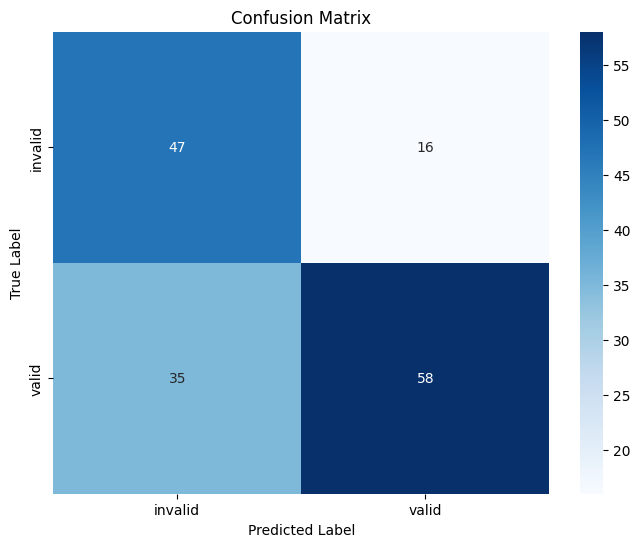

In [39]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Found 51 misclassified samples.
16 samples where invalid was classified as valid:


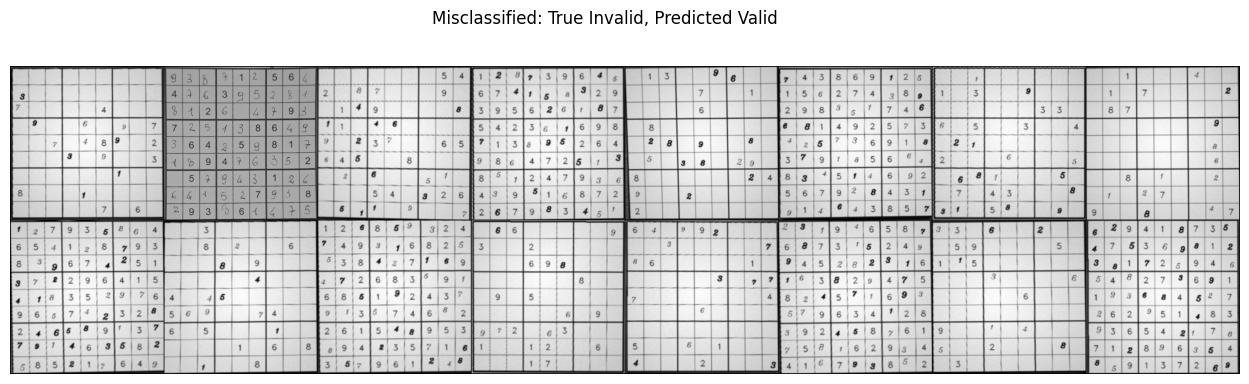

35 samples where valid was classified as invalid:


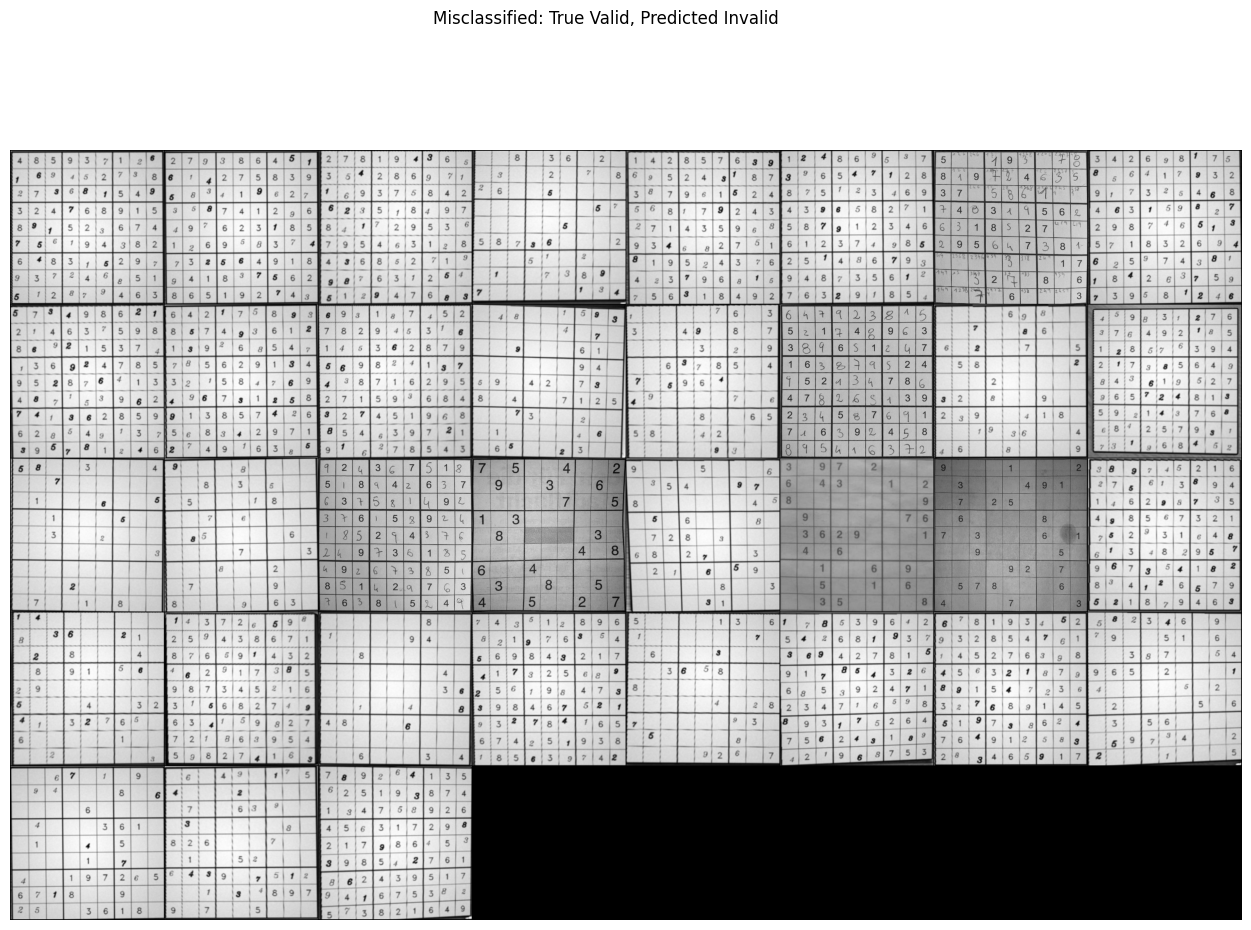

In [40]:
print(f"Found {len(misclassified_images)} misclassified samples.")

invalid_as_valid_images = []
invalid_as_valid_labels = []
invalid_as_valid_preds = []

valid_as_invalid_images = []
valid_as_invalid_labels = []
valid_as_invalid_preds = []

for i in range(len(misclassified_images)):
    true_label = misclassified_labels[i].item()
    pred_label = misclassified_preds[i].item()

    # Case 1: True label is invalid (0) but predicted as valid (1)
    if true_label == dataset.class_to_idx['invalid'] and pred_label == dataset.class_to_idx['valid']:
        invalid_as_valid_images.append(misclassified_images[i])
        invalid_as_valid_labels.append(misclassified_labels[i])
        invalid_as_valid_preds.append(misclassified_preds[i])
    # Case 2: True label is valid (1) but predicted as invalid (0)
    elif true_label == dataset.class_to_idx['valid'] and pred_label == dataset.class_to_idx['invalid']:
        valid_as_invalid_images.append(misclassified_images[i])
        valid_as_invalid_labels.append(misclassified_labels[i])
        valid_as_invalid_preds.append(misclassified_preds[i])

## Plotting Invalid Classified as Valid
print(f"{len(invalid_as_valid_images)} samples where invalid was classified as valid:")
if len(invalid_as_valid_images) > 0:
    n_cols = min(len(invalid_as_valid_images), 8)
    n_rows = math.ceil(len(invalid_as_valid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(invalid_as_valid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Invalid, Predicted Valid", y=1.02)
    plt.show()
else:
    print("No samples where invalid was classified as valid.")

## Plotting Valid Classified as Invalid
print(f"{len(valid_as_invalid_images)} samples where valid was classified as invalid:")
if len(valid_as_invalid_images) > 0:
    n_cols = min(len(valid_as_invalid_images), 8)
    n_rows = math.ceil(len(valid_as_invalid_images) / n_cols)

    grid = torchvision.utils.make_grid(torch.stack(valid_as_invalid_images), nrow=n_cols, padding=2, normalize=True)
    grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.imshow(grid)
    plt.axis('off')
    plt.suptitle("Misclassified: True Valid, Predicted Invalid", y=1.02)
    plt.show()
else:
    print("No samples where Valid was Classified as Invalid.")